# Regression

Imagine that you work for a taxi company, and that one of your customers' biggest complaints is that they don't know how much a ride will cost until it's over. That's because distance is just one of several factors from which taxi fares are calculated. You decide to do something about it by building a mobile app that customers can use when they climb into a taxi to estimate what the fare will be. To provide the smarts for the app, you intend to use the massive amounts of fare data the company has collected over the years to build a machine-learning model.

Regression models predict numeric outcomes such as the price of a car, the age of a person in a picture, or the cost of a taxi ride. Let's use a portion of a larger taxi-fare dataset from New York City to train a regression model to predict a fare amount given the time of day, the pickup and dropoff locations, and other information.

![](Images/nyc.jpg)

## Load and prepare data

Start by loading the dataset and shaping it so that it's suitable for use in machine learning. This dataset is a subset of a much larger dataset containing more than 100 million rows. Recently, the larger dataset was used in Kaggle's [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction) competition. The data requires a fair amount of prep work before it's of any use at all — something that is not uncommon in machine learning. Data scientists often find that collecting and preparing data accounts for 90% or more of their time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

df = pd.read_csv('Data/taxi-fares.csv')
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00 UTC,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00 UTC,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00 UTC,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00 UTC,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00 UTC,-73.921262,40.743615,-73.967383,40.765162,1


How many rows and columns does the dataset contain?

In [2]:
df.shape

(55368, 8)

Are any of the columns missing values?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55368 entries, 0 to 55367
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                55368 non-null  object 
 1   fare_amount        55368 non-null  float64
 2   pickup_datetime    55368 non-null  object 
 3   pickup_longitude   55368 non-null  float64
 4   pickup_latitude    55368 non-null  float64
 5   dropoff_longitude  55368 non-null  float64
 6   dropoff_latitude   55368 non-null  float64
 7   passenger_count    55368 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.4+ MB


Draw a histogram showing how many rows contain a passenger count of 1, how many contain a passenger count of 2, and so on.

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

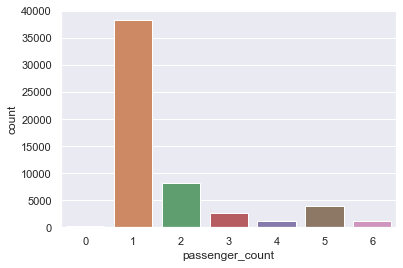

In [4]:
sns.countplot(x=df['passenger_count'])

Most of the rows in the dataset have a passenger count of 1. Remove all rows with multiple passengers and remove the "key" column from the dataset.

In [5]:
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,7.0,2014-06-15 17:11:00 UTC,-73.995420,40.759662,-73.987607,40.751247
2,6.1,2011-02-14 15:14:00 UTC,-73.972380,40.749527,-73.990638,40.745328
4,10.5,2011-07-02 10:38:00 UTC,-73.921262,40.743615,-73.967383,40.765162
5,15.3,2011-12-09 20:03:00 UTC,-73.973500,40.792610,-73.936035,40.856548
8,7.7,2011-04-02 01:05:15 UTC,-73.979564,40.735405,-73.955686,40.768065


How many rows and columns are left in the dataset?

In [6]:
df.shape

(38233, 6)

Find out how much influence input variables such as `latitude` and `longitude` have on the values in the "fare_amount" column.

In [7]:
corr_matrix = df.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount          1.000000
dropoff_longitude    0.020438
pickup_longitude     0.015742
pickup_latitude     -0.015915
dropoff_latitude    -0.021711
Name: fare_amount, dtype: float64

The numbers don't look very encouraging. Latitudes and longitudes have little to do with fare amounts, at least in their present form. And yet intuitively, they should have a *lot* do with fare amounts since they specify starting and ending points and longer rides incur higher fares.

Now comes the fun part: creating whole new columns of data that have more impact on the outcome — columns whose values are computed from values in other columns. Add columns specifying the day of the week (0=Monday, 1=Sunday, and so on), the hour of the day that the passenger was picked up (0-23), and the distance (through the air, not on the street) in miles that the ride covered. To compute distances, this code assumes that most rides are short and that it is therefore safe to ignore the curvature of the earth.

In [8]:
import datetime
from math import sqrt

for i, row in df.iterrows():
    dt = datetime.datetime.strptime(row['pickup_datetime'], '%Y-%m-%d %H:%M:%S UTC')
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6 # 1 degree == 54.6 miles
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0   # 1 degree == 69 miles
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance
    
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day_of_week,pickup_time,distance
0,7.0,2014-06-15 17:11:00 UTC,-73.995420,40.759662,-73.987607,40.751247,6.0,17.0,0.720497
2,6.1,2011-02-14 15:14:00 UTC,-73.972380,40.749527,-73.990638,40.745328,0.0,15.0,1.038136
4,10.5,2011-07-02 10:38:00 UTC,-73.921262,40.743615,-73.967383,40.765162,5.0,10.0,2.924341
5,15.3,2011-12-09 20:03:00 UTC,-73.973500,40.792610,-73.936035,40.856548,4.0,20.0,4.862893
8,7.7,2011-04-02 01:05:15 UTC,-73.979564,40.735405,-73.955686,40.768065,5.0,1.0,2.603493


Remove columns that are no longer needed.

In [9]:
df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,day_of_week,pickup_time,distance
0,7.0,6.0,17.0,0.720497
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493


Run a correlation again.

In [10]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount    1.000000
distance       0.045873
day_of_week    0.009196
pickup_time   -0.019722
Name: fare_amount, dtype: float64

There still isn't a strong correlation between distance traveled and fare amount. Perhaps this will provide some clue as to why:

In [11]:
df.describe()

,fare_amount,day_of_week,pickup_time,distance
count,38233.000000,38233.000000,38233.000000,38233.000000
mean,11.214115,2.951534,13.387989,12.018397
std,9.703149,1.932809,6.446519,217.357022
min,-22.100000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,9.000000,0.762116
50%,8.500000,3.000000,14.000000,1.331326
75%,12.500000,5.000000,19.000000,2.402226
max,256.000000,6.000000,23.000000,4923.837280


The dataset contains outliers, and outliers frequently skew the results of machine-learning models (or prevent them from working at all). Filter the dataset by eliminating negative fare amounts and placing reasonable limits on fares and distance.

In [12]:
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.shape

(23298, 4)

Run a correlation again.

In [13]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount    1.000000
distance       0.851913
day_of_week   -0.003570
pickup_time   -0.023085
Name: fare_amount, dtype: float64

That looks better! The correlation between the day of the week, the hour of the day, and fare amount is still weak, but let's leave those columns in there since it makes sense that it might take longer to get from point A to point B during rush hour, or that traffic at 5:00 p.m. Friday might be different than traffic at 5:00 p.m. on Saturday.

# Train a regression model

Now it's time build a regression model and train it with the data prepared in the previous exercise. We'll try three different regression algorithms to determine which one produces the most accurate results, and use cross-validation to increase our confidence in those results. Start by splitting the data for training and testing.

In [14]:
from sklearn.model_selection import train_test_split

x = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Train a linear-regression model.

In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

What is the model's R-squared score?

In [16]:
model.score(x_test, y_test)

0.7203915544390853

Score the model again using 5-fold cross-validation.

In [17]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, x, y, cv=5).mean()

0.7258845061910324

Measure the model's mean absolute error (MAE).

In [18]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model.predict(x_test))

2.4176905433169273

Now train a `RandomForestRegressor` using the same dataset and see how its accuracy compares.

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0)
model.fit(x_train, y_train)

cross_val_score(model, x, y, cv=5).mean()

0.7061490686850804

Train a third model that uses `GradientBoostingRegressor`.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=0)
model.fit(x_train, y_train)

cross_val_score(model, x, y, cv=5).mean()

0.750496262408626

Which model produced the highest cross-validated coefficient of determination?

## Use the model to predict fare amounts

Finish up by using the trained model to make a pair of predictions. First, estimate what it will cost to hire a taxi for a 2-mile trip at 5:00 p.m. on Friday afternoon.

In [21]:
model.predict([[4, 17, 2.0]])

array([11.33633088])

Now predict the fare amount for a 2-mile trip taken at 5:00 p.m. one day later (on Saturday).

In [22]:
model.predict([[5, 17, 2.0]])

array([10.79265934])

Does the model predict a higher or lower fare amount for the same trip on Saturday afternoon? Does this make sense given that the data comes from a New York City cab company?